# Training a Image Classifier
Simple Image Classifier from PyTorch Official Documentations, you can see original tutorial link [here](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Data from Images
Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

* For images, packages such as `Pillow`, `OpenCV` are useful
* For audio, packages such as `scipy` and `librosa`
* For text, either raw `Python` or `Cython` based loading, or `NLTK` and `SpaCy` are useful

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the `CIFAR10` dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

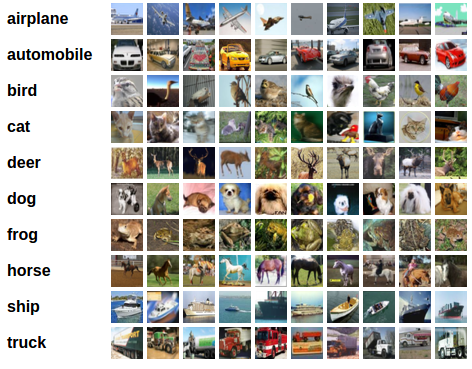

## Training an image classifier

We will do the following steps in order:

- Load and normalize the `CIFAR10` training and test datasets using `torchvision`
- Define a `Convolutional Neural Network`
- Define a `loss function`
- Train the network on the training data
- Test the network on the test data

# 1. Load and Normalize `CIFAR10`
Using `torchvision`, it’s extremely easy to load `CIFAR10`.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

I will explain about code block below

`transforms.Compose[[...]]`

This is a PyTorch utility that chains multiple transform objects together. The data (in this case, an image) will be passed through each transform in the list sequentially. The output of one transform becomes the input of the next. This creates a convenient and organized way to apply a series of operations.

`transforms.ToTensor()`

This is the first step in the pipeline. It performs two key actions:

- Converts a PIL Image or NumPy array to a PyTorch Tensor: Neural networks in PyTorch work with Tensors, so this is a crucial conversion.

- Scales the pixel values: By default, images (e.g., from Pillow or OpenCV) have pixel values in the range of 0 to 255. transforms.ToTensor() automatically scales these values down to the range of 0.0 to 1.0. This normalization is important because large input values can cause issues like exploding gradients during training.

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`

This performs a channel-wise normalization of the tensor. It uses the following formula for each channel:

output=(input−mean)/standard deviation

The arguments (0.5, 0.5, 0.5) represent the mean and standard deviation for each of the three color channels (Red, Green, Blue) of the image.

mean: The first tuple (0.5, 0.5, 0.5) provides the mean value for each channel.

standard deviation: The second tuple (0.5, 0.5, 0.5) provides the standard deviation for each channel.

## Why do we choice 0.5 as mean and standard deviation

The transforms.ToTensor() step scales the pixel values of an image from the original 0-255 range to a new range of 0.0 to 1.0.

If we assume the pixel values in a typical image dataset are roughly and evenly distributed across this 0-1 range, then:

Mean: The average value would be approximately halfway between 0 and 1, which is 0.5.

Standard Deviation: The standard deviation is a measure of how spread out the data is. A value of 0.5 is chosen to scale the entire range of values from [0, 1] to a new range of approximately [-1, 1]. Although it should be calculated for the entire values of rgb mean data, 0.5 is okay for most of the cases. Calculating the actual mean/deviation point may cause computational overhead with no much difference.

Let's look at the formula again: $\text{Output}$ = $\displaystyle \frac{\text{Input} - \text{Mean}}{\text{Standard Deviation}}$

With mean = 0.5 and std = 0.5:

A pixel value of $0.0$ becomes $\frac{0.0 - 0.5}{0.5}$ = $-1.0$

A pixel value of 1.0 becomes (1.0−0.5)/0.5=1.0

A pixel value of 0.5 becomes (0.5−0.5)/0.5=0.0

This effectively centers the data around zero and puts it in a symmetric range, which is generally a good practice for training neural networks.



## Now we will go back to our code

After loading datasets, let's display the images for fun

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Unnormalization Formula Explained

The following code reverses normalization:

```python
img = img / 2 + 0.5
````

This undoes the normalization process defined by:

$$
y = \frac{x - 0.5}{0.5}
$$

Where:

* $x$: original pixel value (after `ToTensor()`) in range $[0, 1]$
* $y$: normalized pixel value in range $[-1, 1]$

---

## Solving for $x$ — the unnormalization

Start with the normalization formula:

$$
y = \frac{x - 0.5}{0.5}
$$

Multiply both sides by 0.5:

$$
0.5y = x - 0.5
$$

Add 0.5 to both sides:

$$
x = 0.5y + 0.5
$$

Which is the same as:

$$
x = \frac{y}{2} + 0.5
$$

---

So, the code:

```python
img = img / 2 + 0.5
```

takes an image tensor in $[-1, 1]$ and transforms it back to the original pixel range $[0, 1]$, which is suitable for visualization or saving.


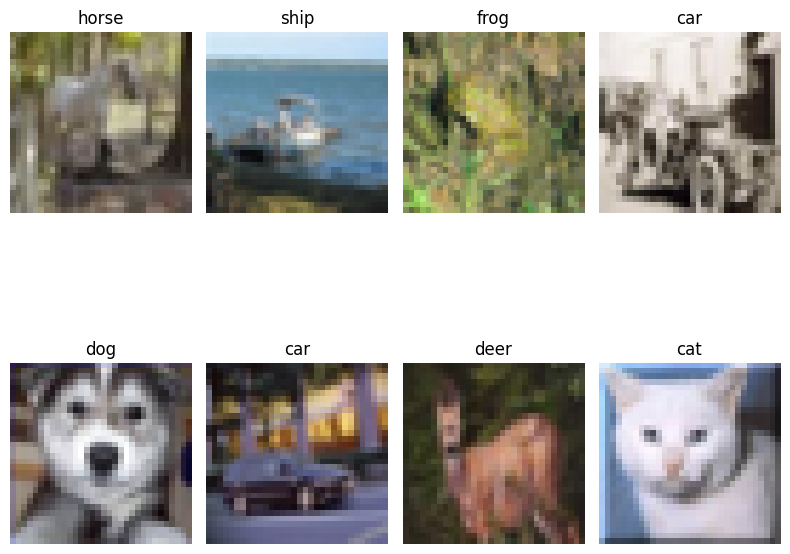

In [4]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a figure and a set of subplots
# The figsize can be adjusted for a better look of the 32x32 images
fig, axes = plt.subplots(2, 4, figsize=(8, 8)) 
axes = axes.flatten()  # Flatten the 4x4 array of axes into a 1D array

# Unnormalize the images before plotting
images = images / 2 + 0.5

# Iterate through the images and labels
for i in range(8):
    # The shape of each image tensor is (3, 32, 32)
    # We transpose it to (32, 32, 3) for Matplotlib
    img = np.transpose(images[i].numpy(), (1, 2, 0))

    # Plot the 32x32 image on the corresponding subplot
    axes[i].imshow(img)

    # Set the title to be the class label
    axes[i].set_title(classes[labels[i]])

    # Turn off the axes ticks for a cleaner look
    axes[i].axis('off')

# Adjust the layout to prevent titles from overlapping
plt.tight_layout()

# Show the plot
plt.show()

## 2.Define a Convolutional Neural Network
We will define a Convolutional Neural Network Below

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# --- Add this block to define your device ---
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # After First conv 28 x 28 x 6
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5 kernel_size

        # Pooling by 2 x 2, stride = 1 by default
        self.pool = nn.MaxPool2d(2, 2) # kernel size, stride ( defaults to 1 )
        # After Pooling of conv1, self.pool(self.conv1) = 14 x 14 x 6 ( h x w x out_channels )

        # After Second conv 10 x 10 x 16 -> ( h x w x out_channels )
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5 kernel_size
        # After Pooling of conv2, self.pool(self.conv2) = 5 x 5 x 16 -> ( h x w x out_channels)
        
        # 16 * 5 * 5, This is a fixed requirement that is calculated from the output of the final convolutional and pooling layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device, dtype=torch.float32)

Using device: mps


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Convolution and Pooling Part Explained

Here's a step-by-step derivation of convolution and pooling parts:

### 1. After `conv1` and `pool`: The derivation of `14x14x6`

**Starting Point:** The input image tensor has a shape of `(batch_size, 3, 32, 32)`.

**Step 1: The Convolutional Layer (`self.conv1 = nn.Conv2d(3, 6, 5)`)**

We use the convolutional output size formula for the spatial dimensions (height and width):

$Output\_size = \lfloor (Input\_size - Kernel\_size + 2 \times Padding) / Stride \rfloor + 1$

For `conv1`, we have:
* `Input_size`: 32
* `Kernel_size`: 5
* `Padding`: 0 (default)
* `Stride`: 1 (default)

Let's plug in the numbers:
$Output\_size = \lfloor (32 - 5 + 2 \times 0) / 1 \rfloor + 1 = 27 + 1 = 28$

So, the spatial dimensions are reduced from 32x32 to 28x28. The number of channels is determined by `conv1`'s `out_channels`, which is 6.
* **Output of `conv1`**: `28x28x6`

**Step 2: The Pooling Layer (`self.pool = nn.MaxPool2d(2, 2)`)**

The max-pooling layer with a `kernel_size=2` and `stride=2` halves the spatial dimensions of its input.
* Input height: 28
* Input width: 28

* New height: $28 / 2 = 14$
* New width: $28 / 2 = 14$

The number of channels remains unchanged.
* **Output of `pool`**: `14x14x6`

This confirms the first derived size.

### 2. After `conv2` and `pool`: The derivation of `5x5x16`

**Starting Point:** The input to the `conv2` layer is the output of the first pooling layer, which has a shape of `(batch_size, 6, 14, 14)`.

**Step 1: The Convolutional Layer (`self.conv2 = nn.Conv2d(6, 16, 5)`)**

We use the same convolutional output size formula, but with the new input size.
* `Input_size`: 14
* `Kernel_size`: 5
* `Padding`: 0 (default)
* `Stride`: 1 (default)

Let's plug in the numbers:
$Output\_size = \lfloor (14 - 5 + 2 \times 0) / 1 \rfloor + 1 = 9 + 1 = 10$

So, the spatial dimensions are reduced from 14x14 to 10x10. The number of channels is determined by `conv2`'s `out_channels`, which is 16.
* **Output of `conv2`**: `10x10x16`

**Step 2: The Pooling Layer (`self.pool = nn.MaxPool2d(2, 2)`)**

The output of `conv2` is passed to the same max-pooling layer, which halves the spatial dimensions.
* Input height: 10
* Input width: 10

* New height: $10 / 2 = 5$
* New width: $10 / 2 = 5$

The number of channels remains unchanged.
* **Output of `pool`**: `5x5x16`

This confirms the second derived size.

### The Final Step: Flattening for the Fully Connected Layers

The final output of the convolutional part of the network is a tensor with a shape of `(batch_size, 16, 5, 5)`. The `torch.flatten(x, 1)` operation then takes the product of the last three dimensions to create a single vector for the `nn.Linear` layers.

$16 \times 5 \times 5 = 400$

This is why the first fully connected layer is defined as `nn.Linear(16 * 5 * 5, 120)`, which is the same as `nn.Linear(400, 120)`. The `16 * 5 * 5` is not a magic number, but a direct result of the architecture's design.

### Understanding `self.conv1 = nn.Conv2d(3, 6, 5)`

The parameters chosen for `self.conv1 = nn.Conv2d(3, 6, 5)` are a common starting point for a simple `CNN`, particularly for small images like the `32x32` images in the `CIFAR-10` dataset. Let's break down the reasoning behind each number:

---

#### Syntax

```python
nn.Conv2d(in_channels, out_channels, kernel_size)
```

The `nn.Conv2d` layer takes three main arguments:

* `in_channels`
* `out_channels`
* `kernel_size`

---

### 1. `in_channels = 3`

**Reasoning**:
This is determined by the input data. The images we are processing are RGB (Red, Green, Blue), and each color is a separate channel.

**Explanation**:
A convolutional layer’s `in_channels` must match the number of channels of the input tensor.
For standard color images:

```
Input shape: (batch_size, 3, height, width)
```

Thus, we set `in_channels = 3` to process the 3 color channels.

---

### 2. `out_channels = 6`

**Reasoning**:
This is a design choice — a small, manageable number for a beginner model.

**Explanation**:
The `out_channels` defines the number of **filters** (or **feature maps**) the layer will learn.
Each filter detects a specific feature (e.g., horizontal edge, vertical line, texture, etc.).

Setting `out_channels = 6` means:

* The model will learn 6 filters.
* The output will have 6 channels (1 per filter).

**Alternative Choices**:

* Larger values like `16`, `32`, or `64` allow learning more complex features.
* Higher values increase **model size** and **computational cost**.

---

### 3. `kernel_size = 5`

**Reasoning**:
A `5x5` kernel is a good default for detecting features in small images.

**Explanation**:
`kernel_size` determines the spatial size of the filter.

* A `5x5` filter scans a `5x5` region of the image.
* Larger receptive field = more context per filter.

**Alternative Choices**:

* `3x3`:

  * More common in modern CNNs.
  * Better at learning fine-grained features.
  * Two stacked `3x3` layers ≈ one `5x5` layer with fewer parameters.

* `7x7` or larger:

  * Captures more global patterns.
  * More expensive and may lose detail on small images.

---

The line `self.pool = nn.MaxPool2d(2, 2)` defines a max-pooling layer, which is a crucial component of most modern Convolutional Neural Networks (CNNs). It serves to downsample the feature maps produced by the convolutional layers, which has several benefits.

Let's break down the parameters: `nn.MaxPool2d(kernel_size, stride)`.

### 1. `kernel_size = 2`

* **Reasoning:** A `kernel_size` of `2` is a standard and effective choice for max-pooling.
* **Explanation:** This parameter specifies the size of the window over which the pooling operation is performed.
    * A `kernel_size` of `2` means that the layer will look at a **2x2 pixel region** of the input feature map at a time.
    * Within this 2x2 window, it will select the **maximum value** and discard the other three. This is why it's called "max" pooling.

### 2. `stride = 2`

* **Reasoning:** A `stride` of `2` is chosen to perfectly match the `kernel_size`, which results in a downsampling of the input by a factor of 2.
* **Explanation:** The `stride` parameter determines how many pixels the pooling window moves at each step.
    * A `stride` of `2` means that after looking at one 2x2 window, the layer will move **2 pixels to the right** before looking at the next window.
    * Since the window size is also 2, there is no overlap between consecutive pooling operations.
    * This non-overlapping behavior is what makes the layer so effective at reducing the spatial dimensions.

### How it works on a feature map:

Imagine a 4x4 input feature map:

| 1 | 2 | 3 | 4 |
|---|---|---|---|
| 5 | 6 | 7 | 8 |
| 9 | 10| 11| 12|
| 13| 14| 15| 16|

The `nn.MaxPool2d(2, 2)` layer will process this in four steps:

1.  **First window:** It looks at the top-left 2x2 region: `[[1, 2], [5, 6]]`. The maximum value is **6**.
2.  **Second window:** It moves 2 pixels to the right and looks at `[[3, 4], [7, 8]]`. The maximum value is **8**.
3.  **Third window:** It moves 2 pixels down and 2 pixels left to look at `[[9, 10], [13, 14]]`. The maximum value is **14**.
4.  **Fourth window:** It moves 2 pixels to the right to look at `[[11, 12], [15, 16]]`. The maximum value is **16**.

The output of the pooling layer is a new, smaller feature map:

| 6 | 8 |
|---|---|
| 14| 16|

The original 4x4 feature map has been downsampled to a 2x2 feature map. The spatial dimensions (height and width) have been reduced by half.

### Why is max-pooling used in CNNs?

1.  **Dimensionality Reduction:** It reduces the spatial size of the feature maps, which drastically reduces the number of parameters and computation in the network. This makes the model faster and less prone to overfitting.
2.  **Feature Extraction:** By taking the maximum value in a window, max-pooling highlights the most important or "activated" features in that region. It retains the most prominent features while discarding less relevant information.
3.  **Translational Invariance:** Max-pooling makes the network more robust to small translations (shifts) of the features in the input image. If a feature (e.g., an edge) moves slightly within a 2x2 window, the maximum value will still be detected, resulting in the same output. This helps the network recognize objects even if they are in slightly different positions.

---
The definition `self.conv2 = nn.Conv2d(6, 16, 5)` is a logical next step in the CNN architecture we've defined. Its parameters are directly influenced by the output of the preceding layers.

Let's break down the reasons behind each parameter.

### Context: The State of the Data Before `conv2`

To understand why `self.conv2` is configured this way, we need to know the output shape of the previous layers. Starting with a 32x32 RGB image:

1.  **Input:** `32x32x3` (Height x Width x Channels)
2.  **`conv1` (`nn.Conv2d(3, 6, 5)`):** This layer takes the 3-channel image and produces 6 feature maps. The spatial dimensions are reduced from 32 to `32 - 5 + 1 = 28`.
    * **Output of `conv1`:** `28x28x6`
3.  **`pool` (`nn.MaxPool2d(2, 2)`):** This layer halves the spatial dimensions of the feature maps.
    * **Output of `pool`:** `14x14x6`

The `conv2` layer's job is to process this `14x14x6` tensor.

### 1. `in_channels = 6`

* **Reasoning:** This parameter must match the number of output channels from the previous layer.
* **Explanation:** The output of the first pooling layer is a tensor with 6 channels. The `conv2` layer needs to take these 6 channels as its input. Each of the 16 filters in `conv2` will now operate on all 6 of these channels simultaneously to produce a single output value.

### 2. `out_channels = 16`

* **Reasoning:** This is a design choice and a hyperparameter. The number 16 is a larger number of filters than the previous layer, which is a common practice in CNNs.
* **Explanation:**
    * As the network goes deeper, the convolutional layers often learn more complex and abstract features. To capture this greater complexity, it's common to increase the number of filters.
    * The first layer (`conv1`) learned 6 basic features (e.g., simple edges or color blobs).
    * The second layer (`conv2`) will now learn 16 more complex features by combining the simple features from the first layer. For example, `conv2` might learn to detect the combination of edges that form a corner or a more intricate texture.
* **Why not 12 or 32?** The number 16 is a power of 2, which is a convention often used in deep learning for computational efficiency and memory management. It's also a moderate increase from 6, providing more learning capacity without being overly complex for this simple network.

### 3. `kernel_size = 5`

* **Reasoning:** A `kernel_size` of `5` is a straightforward choice, continuing the pattern from the first convolutional layer. It allows the layer to look at a relatively wide area of the previous layer's output.
* **Explanation:** The 5x5 kernel will slide over the `14x14` spatial dimensions of the input tensor. Since the output of the pooling layer is smaller, this 5x5 kernel is now looking at a larger "receptive field" of the original image.
* **Calculation:** The spatial dimensions will be reduced again. With a 14x14 input and a 5x5 kernel (and a default stride of 1), the output size is `14 - 5 + 1 = 10`. So, the output of `conv2` will be `10x10x16`. This output is then passed to the next pooling layer.

### Summary:

The configuration `self.conv2 = nn.Conv2d(6, 16, 5)` is a logical progression:

* **`6` (in_channels):** It correctly receives the 6 feature maps from the previous pooling layer.
* **`16` (out_channels):** It increases the number of filters to learn more complex features in the deeper part of the network.
* **`5` (kernel_size):** It continues to use a reasonably sized filter to process the feature maps.

---
This set of lines defines the fully connected (or dense) layers of your neural network. These layers are responsible for taking the high-level features extracted by the convolutional layers and using them to make a final classification decision.

Let's break down each line.

### Context: The State of the Data Before `fc1`

Before the data reaches these layers, it has gone through the convolutional and pooling layers. As we calculated earlier for a 32x32 input image:

* **Output of `conv1` followed by `pool`**: `14x14x6`
* **Output of `conv2` followed by `pool`**: `5x5x16`

This output is a 3D tensor. Fully connected layers, however, expect a 1D vector as input. This is why the `forward` method includes the line `x = torch.flatten(x, 1)`, which reshapes the `5x5x16` tensor into a single, long vector.

The size of this vector is `16 * 5 * 5 = 400`. This is the input size for the first fully connected layer.

### `self.fc1 = nn.Linear(16 * 5 * 5, 120)`

* **`nn.Linear(in_features, out_features)`**: This is the PyTorch class for a fully connected layer. It performs a linear transformation on the input data: `y = xA^T + b`.
* **`in_features = 16 * 5 * 5 = 400`**: This is the number of input features. It corresponds to the total number of elements in the flattened tensor that comes from the last pooling layer. It's crucial that this number is calculated correctly, as it represents the "size" of the data entering the fully connected part of the network.
* **`out_features = 120`**: This is the number of neurons in this layer. This is a hyperparameter that you can choose. The number `120` is an arbitrary but reasonable choice for a small network. This layer takes the 400 input features and combines them in 120 different ways. The output of this layer will be a vector of size 120.

### `self.fc2 = nn.Linear(120, 84)`

* **`in_features = 120`**: The input to this layer is the output of the previous layer, `fc1`. Therefore, its input features must match the output features of `fc1`.
* **`out_features = 84`**: This is another design choice. The number `84` is simply a common choice to reduce the dimensionality of the features further before the final output layer. The output of this layer will be a vector of size 84.

### `self.fc3 = nn.Linear(84, 10)`

* **`in_features = 84`**: The input to this layer is the output of `fc2`.
* **`out_features = 10`**: This is the final layer of the network, and its `out_features` must correspond to the number of classes in your classification problem.
    * For a dataset like CIFAR-10, there are 10 distinct classes (plane, car, bird, etc.).
    * The output of this layer will be a vector of size 10. Each of the 10 numbers in this vector represents the model's confidence score (or "logit") for each class.
    * These scores are then typically passed to a loss function like `nn.CrossEntropyLoss` to calculate the error and train the network.

### Summary: The purpose of these layers

1.  **`fc1`**: Takes the flattened tensor of features from the convolutional layers and transforms it into a smaller, 120-dimensional vector. This can be thought of as a first level of feature abstraction for the classifier.
2.  **`fc2`**: Takes the 120-dimensional vector and further compresses it into an 84-dimensional vector. This helps the network learn an even more compact and abstract representation of the features.
3.  **`fc3`**: Takes the final 84-dimensional vector and maps it to a 10-dimensional vector, where each element represents the unnormalized probability (logit) of the input image belonging to one of the 10 classes.

---

## Role of Fully Connected Layers

This part of the code defines the fully connected (or dense) layers of the neural network. These layers are crucial because they take the high-level features that have been extracted by the convolutional and pooling layers and use them to make a final classification decision.

Think of the convolutional layers as the "feature extractors" and the fully connected layers as the "classifiers."

After the second pooling layer, the data has a shape of `(batch_size, 16, 5, 5)`. The fully connected layers, however, operate on 1D vectors. This is why the `forward` function first uses `torch.flatten(x, 1)` to reshape the tensor into a single, long vector.

The size of this vector is `16 * 5 * 5 = 400`. This flattened vector is the input to the first fully connected layer.

### 1. `self.fc1 = nn.Linear(16 * 5 * 5, 120)`

* **`nn.Linear`**: This is PyTorch's class for a fully connected layer. It's a linear transformation where every input neuron is connected to every output neuron, followed by a bias term.
* **`in_features = 16 * 5 * 5`**: This is a **fixed requirement**. The input size to this layer must exactly match the number of features in the flattened tensor coming from the last pooling layer. The number `16 * 5 * 5 = 400` is not a random choice; it's a consequence of the convolutional architecture's design.
* **`out_features = 120`**: This is a **hyperparameter** and a **design choice**. It represents the number of neurons in this hidden layer. The number `120` is a reasonable value to start with for a simple network. This layer takes the 400 features and learns to transform them into a more abstract, 120-dimensional representation.

### 2. `self.fc2 = nn.Linear(120, 84)`

* **`in_features = 120`**: This is a **fixed requirement**. The input size to this layer must exactly match the output size of the previous layer (`fc1`).
* **`out_features = 84`**: This is another **hyperparameter** and a **design choice**. The number `84` is a bit arbitrary but is often used to further reduce the dimensionality before the final output layer. It's a common choice in simple network architectures.

### 3. `self.fc3 = nn.Linear(84, 10)`

* **`in_features = 84`**: This is a **fixed requirement**, matching the output size of the previous layer (`fc2`).
* **`out_features = 10`**: This is a **fixed requirement** determined by the classification task. The network is designed to classify images into one of 10 classes (e.g., in the CIFAR-10 dataset). The final layer must have 10 output neurons to provide a prediction score, or **logit**, for each of the 10 classes.

### Summary

The `fc` layers take the abstract features from the convolutional layers and perform a series of transformations. The number of neurons in these layers (`120` and `84`) are hyperparameters chosen by the network's designer, while the input and output sizes of the first and last layers (`400` and `10`) are fixed by the network's architecture and the number of classes in the dataset, respectively.

### Below Diagram Represent How Our Neural Network is Forwarded from raw data to output result

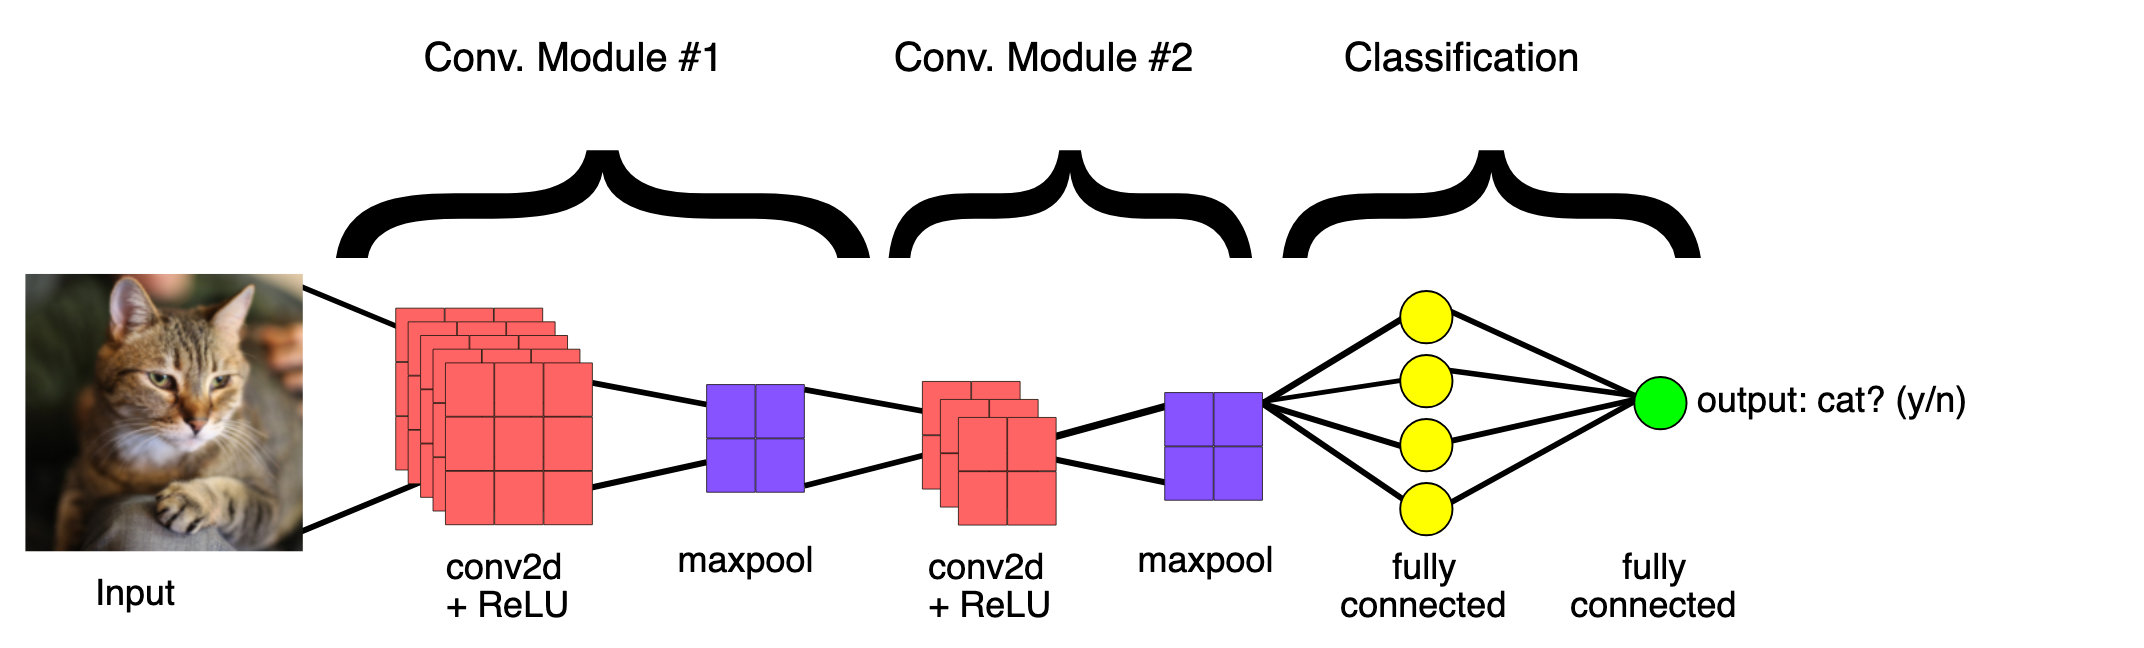

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Loss function and optimizer

We'll use [Cross-Entropy loss](https://www.youtube.com/watch?v=FODwUM-1PyI) and [SGD with momentum](https://www.youtube.com/watch?v=UmathvAKj80). I've attached Explaination Videos respective to the titles.

These two lines of code are essential for training any neural network in PyTorch. They define the **loss function** and the **optimizer**, which together form the core feedback loop of the learning process.

### `criterion = nn.CrossEntropyLoss()`

This line defines the **loss function**, also known as the criterion.

* **What it is:** `nn.CrossEntropyLoss` is a class from PyTorch's neural network module that computes the cross-entropy loss.
* **Its Purpose:** A loss function measures the discrepancy between the network's predictions and the actual ground truth labels. It outputs a single numerical value that quantifies how "wrong" the model's predictions are. A lower loss value means the model is performing better.
* **Why `CrossEntropyLoss`?**
    1.  **For Classification:** This loss function is the standard choice for multi-class classification problems. Since your network (`Net`) is designed to classify images into one of 10 classes, `CrossEntropyLoss` is the most appropriate choice.
    2.  **Combines Operations:** It intelligently combines two steps: a `softmax` operation and the negative log-likelihood loss. This is beneficial because the final layer of your network (`fc3`) outputs raw scores (logits), and `CrossEntropyLoss` handles the conversion of these scores into probabilities and calculates the loss in a single, numerically stable step. This prevents potential issues with floating-point arithmetic.
    3.  **Input:** It expects the raw, unnormalized scores (logits) from the final layer of your network as its first argument and the integer-based class labels (e.g., `[3, 8, 1]`) as its second argument.

### `optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)`

This line defines the **optimizer**, which is the engine that drives the learning.

* **What it is:** `optim.SGD` is PyTorch's implementation of the Stochastic Gradient Descent (SGD) algorithm, which is one of the most fundamental optimization algorithms used in deep learning.
* **Its Purpose:** An optimizer's job is to update the network's parameters (weights and biases) in the direction that minimizes the loss. It uses the gradients calculated during the backward pass (backpropagation) to determine how each parameter should be adjusted.
* **Why these arguments?**
    1.  **`net.parameters()`**: This is the most crucial argument. It provides the optimizer with a list of all the network's trainable parameters (the weights and biases of all layers). The optimizer needs to know exactly which values to adjust. By passing `net.parameters()`, you are telling the optimizer to update every single weight and bias in your `Net` model.
    2.  **`lr=0.001`**: This is the **learning rate**. It is a hyperparameter that controls the step size of the parameter updates. A small learning rate means the updates will be small and cautious, which can lead to slow convergence but is often more stable. A large learning rate can speed up convergence but risks overshooting the optimal solution. A value of `0.001` is a common and conservative starting point for many models.
    3.  **`momentum=0.9`**: This is an extension to standard SGD. It helps accelerate the optimizer in the right direction and dampens oscillations. Think of it as a "ball rolling downhill." Instead of just reacting to the current gradient (slope), it also remembers the previous updates and continues moving in that direction. This helps the optimizer escape shallow local minima and converge faster. A momentum value of `0.9` is a very common and effective choice.

### How they work together

In the training loop, these two components work in a tight feedback loop:

1.  **Forward Pass**: The network processes an image and produces a prediction.
2.  **Loss Calculation**: The `criterion` compares the prediction with the ground truth label and calculates the loss.
3.  **Backward Pass**: PyTorch's `autograd` engine calculates the gradients (the derivative of the loss with respect to each parameter).
4.  **Parameter Update**: The `optimizer` uses the calculated gradients and its settings (`lr`, `momentum`) to update the network's parameters, taking a step toward minimizing the loss.

## Train the neural network


In [20]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move data to device
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.191
[1,  4000] loss: 1.765
[1,  6000] loss: 1.589
[2,  2000] loss: 1.465
[2,  4000] loss: 1.409
[2,  6000] loss: 1.365
[3,  2000] loss: 1.290
[3,  4000] loss: 1.266
[3,  6000] loss: 1.227
[4,  2000] loss: 1.161
[4,  4000] loss: 1.144
[4,  6000] loss: 1.143
[5,  2000] loss: 1.072
[5,  4000] loss: 1.077
[5,  6000] loss: 1.071
[6,  2000] loss: 0.995
[6,  4000] loss: 1.012
[6,  6000] loss: 1.017
[7,  2000] loss: 0.941
[7,  4000] loss: 0.956
[7,  6000] loss: 0.960
[8,  2000] loss: 0.887
[8,  4000] loss: 0.909
[8,  6000] loss: 0.917
[9,  2000] loss: 0.843
[9,  4000] loss: 0.866
[9,  6000] loss: 0.882
[10,  2000] loss: 0.792
[10,  4000] loss: 0.822
[10,  6000] loss: 0.845
[11,  2000] loss: 0.777
[11,  4000] loss: 0.780
[11,  6000] loss: 0.818
[12,  2000] loss: 0.722
[12,  4000] loss: 0.763
[12,  6000] loss: 0.786
[13,  2000] loss: 0.697
[13,  4000] loss: 0.727
[13,  6000] loss: 0.753
[14,  2000] loss: 0.663
[14,  4000] loss: 0.708
[14,  6000] loss: 0.730
[15,  2000] loss: 0

In [21]:
PATH = './models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.
Okay, first step. Let us display an image from the test set to get familiar.


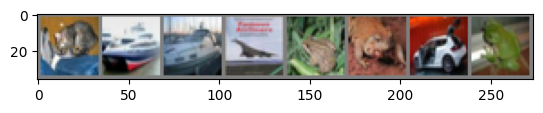

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [24]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [26]:
outputs = net(images)

In [27]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

Predicted:  cat   ship  ship  plane deer  frog  dog   frog 


The result seems pretty good, we only miss some values. 
Let's looks up how our model perform on the whole dataset :)

In [28]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


Cool, this look way better than chance which is just about 10% ( random pick of 10 classes). Seems like our network learned something.
Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [29]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 66.3 %
Accuracy for class: car   is 77.2 %
Accuracy for class: bird  is 49.4 %
Accuracy for class: cat   is 47.6 %
Accuracy for class: deer  is 54.7 %
Accuracy for class: dog   is 54.5 %
Accuracy for class: frog  is 70.1 %
Accuracy for class: horse is 62.4 %
Accuracy for class: ship  is 77.8 %
Accuracy for class: truck is 72.3 %
